In [55]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint, Bounds

from multirtd.utils import rand_in_bounds
from multirtd.dubins_model import dubins_traj

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
dt = 0.1
T = 1.5  # 15 steps
N = int(T / dt)
init_pose = np.array([0, 0, 0])
goal = np.array([2, 0])

U = np.tile(np.array([1, 0]), (N, 1))
start_time = time.time()
for i in range(10000):
    dubins_traj(init_pose, U, dt)
print("Time elapsed: {:.3f} s".format(time.time() - start_time))

# TODO: add braking maneuver

Time elapsed: 0.799 s


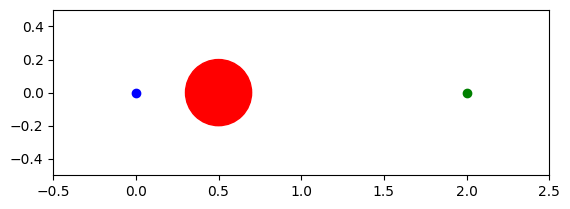

In [64]:
# Trajectory parameter space
v_max = 0.25  # [m/s]
w_max = 1.0  # [rad/s]

# Obstacle
obs_c = np.array([0.5, 0])
obs_r = 0.2

# Plot
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 0.5)
# Plot obstacle and start and goal
ax.add_artist(plt.Circle(obs_c, obs_r, color='r'))
ax.plot(init_pose[0], init_pose[1], 'bo')
ax.plot(goal[0], goal[1], 'go')


### Sampled-based

In [65]:
# Sample-based

start_time = time.time()
n_samples = 1000
u_samples = rand_in_bounds([-v_max, v_max, -w_max, w_max], n_samples)
endpoints = np.zeros((n_samples, 2))
for i, u in enumerate(u_samples):
    U = np.tile(u, (N, 1))
    traj = dubins_traj(init_pose, U, dt)
    endpoints[i] = traj[-1,:-1]

dists = np.linalg.norm(endpoints - goal, axis=1)
sort_idxs = np.argsort(dists)
u_samples_sorted = u_samples[sort_idxs]

# Check collisions
for u in u_samples_sorted:
    U = np.tile(u, (N, 1))
    traj = dubins_traj(init_pose, U, dt)
    d_vec = np.linalg.norm(traj[:,:-1] - obs_c, axis=1)
    if any(d_vec <= obs_r):
        continue
    else:
        print("found plan ", u)
        break
print("Time elapsed: {:.3f} s".format(time.time() - start_time))

found plan  [0.24304839 0.50020339]
Time elapsed: 0.080 s


In [66]:
traj = dubins_traj(init_pose, np.tile(u, (N, 1)), dt)
print(traj)
print(np.linalg.norm(traj[-1,:-1] - goal))

[[0.         0.         0.        ]
 [0.02430484 0.         0.05002034]
 [0.04857928 0.00121523 0.10004068]
 [0.0727626  0.00364265 0.15006102]
 [0.0967943  0.00727618 0.20008136]
 [0.12061426 0.01210675 0.2501017 ]
 [0.14416291 0.01812226 0.30012204]
 [0.16738134 0.02530766 0.35014238]
 [0.19021145 0.03364499 0.40016272]
 [0.21259615 0.04311338 0.45018306]
 [0.23447944 0.05368915 0.50020339]
 [0.25580657 0.06534585 0.55022373]
 [0.2765242  0.07805432 0.60024407]
 [0.2965805  0.09178276 0.65026441]
 [0.31592529 0.10649683 0.70028475]]
1.687438647609733


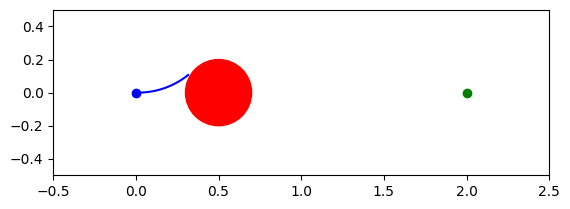

In [67]:
# Plot trajectory
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 0.5)
# Plot obstacle and start and goal
ax.add_artist(plt.Circle(obs_c, obs_r, color='r'))
ax.plot(init_pose[0], init_pose[1], 'bo')
ax.plot(goal[0], goal[1], 'go')
ax.plot(traj[:,0], traj[:,1], 'b-')

### Scipy optimize

In [68]:
# Optimization-based
def cost(u):
    U = np.tile(u, (N, 1))
    traj = dubins_traj(init_pose, U, dt)
    dist = np.linalg.norm(traj[-1,:-1] - goal)
    return dist

def constraint(u):
    U = np.tile(u, (N, 1))
    traj = dubins_traj(init_pose, U, dt)
    dist = np.linalg.norm(traj[:,:-1] - obs_c, axis=1)
    return dist

start_time = time.time()
cons = NonlinearConstraint(constraint, obs_r, np.inf)
res = minimize(cost, np.array([0, 0]), method='SLSQP', bounds=[(-v_max, v_max), (-w_max, w_max)], constraints=cons, options={'disp': True})
print("Time elapsed: {:.3f} s".format(time.time() - start_time))
print(res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.6999999996806896
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
Time elapsed: 0.004 s
[0.21428571 0.        ]


In [69]:
traj = dubins_traj(init_pose, np.tile(res.x, (N, 1)), dt)
print(traj)
print(np.linalg.norm(traj[-1,:-1] - goal))

[[0.         0.         0.        ]
 [0.02142857 0.         0.        ]
 [0.04285714 0.         0.        ]
 [0.06428571 0.         0.        ]
 [0.08571429 0.         0.        ]
 [0.10714286 0.         0.        ]
 [0.12857143 0.         0.        ]
 [0.15       0.         0.        ]
 [0.17142857 0.         0.        ]
 [0.19285714 0.         0.        ]
 [0.21428571 0.         0.        ]
 [0.23571429 0.         0.        ]
 [0.25714286 0.         0.        ]
 [0.27857143 0.         0.        ]
 [0.3        0.         0.        ]]
1.6999999996806896


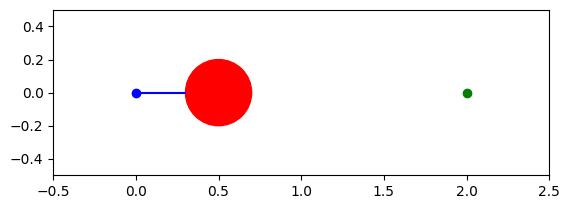

In [70]:
# Plot trajectory
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 0.5)
# Plot obstacle and start and goal
ax.add_artist(plt.Circle(obs_c, obs_r, color='r'))
ax.plot(init_pose[0], init_pose[1], 'bo')
ax.plot(goal[0], goal[1], 'go')
ax.plot(traj[:,0], traj[:,1], 'b-')

### With zonotope constraints

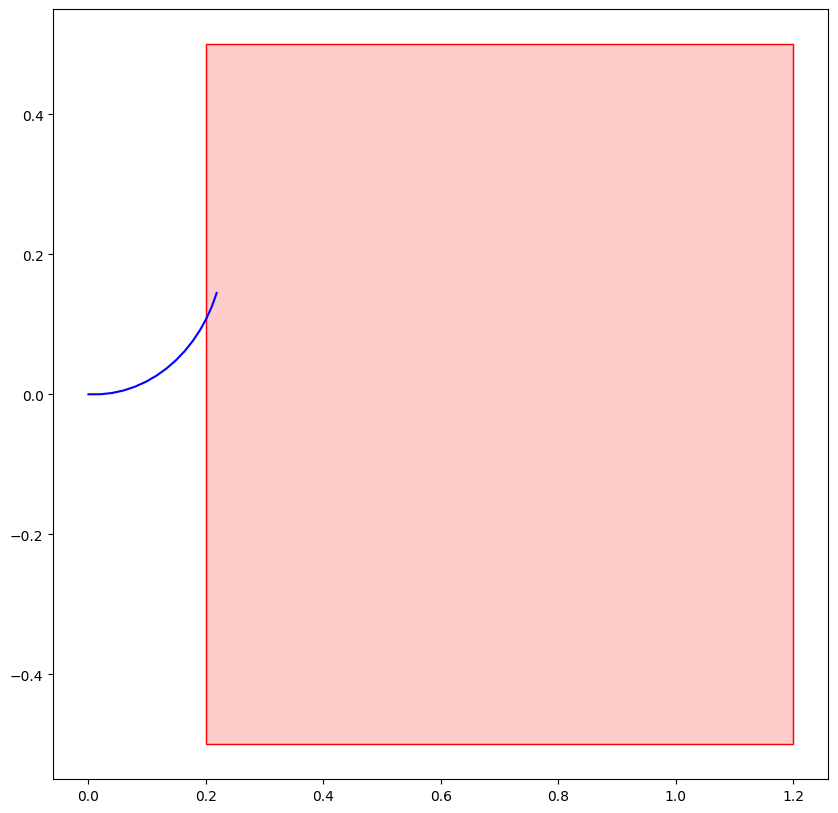

In [43]:
import matplotlib.pyplot as plt

import multirtd.utils as utils
from multirtd.zonotope import Zonotope

obs_c = np.array([0.7, 0])[:,None]
obs_G = 0.5 * np.eye(2)
obs = Zonotope(obs_c, obs_G)

u = np.array([0.2, 0.9])
traj = dubins_traj(init_pose, np.tile(u, (N, 1)), dt)

fig, ax = plt.subplots(figsize=(10,10))

obs.plot(ax, color='r')
ax.plot(traj[:,0], traj[:,1], 'b')

In [71]:
u = np.array([0.25, 0.5])
traj = dubins_traj(init_pose, np.tile(u, (N, 1)), dt)

In [30]:
from multirtd.LPM import LPM
from multirtd.reachability import compute_PRS

LPM_file = os.path.join(os.getcwd(),'..', 'models', 'quadrotor_linear_planning_model.mat')
lpm = LPM(LPM_file)
PRS = compute_PRS(lpm, np.zeros((2,1)), np.zeros((2,1)), np.zeros((2,1)))

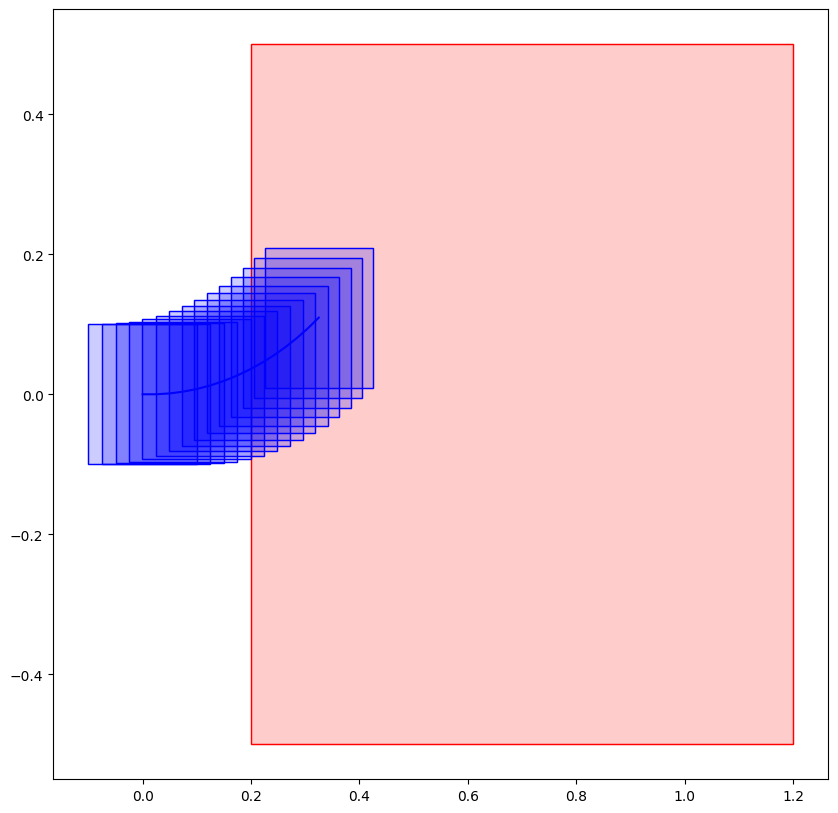

In [72]:
fig, ax = plt.subplots(figsize=(10,10))

obs.plot(ax, color='r')
ax.plot(traj[:,0], traj[:,1], 'b')

ers = Zonotope(np.zeros((2, 1)), 0.1 * np.eye(2))
u_zono = Zonotope(np.zeros((2, 1)), 0.1 * np.eye(2))
frs = []
for i in range(N):
    zono = ers + traj[i,:-1][:,None]
    zono.augment(u_zono)
    frs.append(zono)
    zono.plot(ax, color='b')

In [73]:
def check_collision_constraints(A_con, b_con, v_peak):
    """Check a trajectory parameter against halfspace collision constraints.
    
    Parameters
    ----------
    A_con : list
        List of halfspace constraint matrices
    b_con : list
        List of halfspace constraint vectors
    v_peak : np.array (N_DIM x 1)
        Trajectory parameter

    Returns
    -------
    bool
        True if the trajectory is safe, False if it results in collision

    """
    c = np.inf

    # Get the coefficients of the parameter space zonotope for this parameter
    # Assumes parameter space zonotope is centered at 0, v_max generators
    lambdas = v_peak / v_max

    for (A, b) in zip(A_con, b_con):
        c_tmp = A @ lambdas - b  # A*lambda - b <= 0 means inside unsafe set
        c_tmp = c_tmp.max()  # Max of this <= 0 means inside unsafe set
        c = min(c, c_tmp)  # Find smallest max. If it's <= 0, then parameter is unsafe
    
    return c

In [40]:
from multirtd.reachability import generate_collision_constraints_FRS

A_con, b_con = generate_collision_constraints_FRS(PRS, [obs])
check_collision_constraints(A_con, b_con, np.array([0.1, 0])[:,None])

-1.0

In [ ]:
goal = np.array([5, 2])

def cost(u):
    U = np.tile(u, (N, 1))
    traj = dubins_traj(init_pose, U, dt)
    dist = np.linalg.norm(traj[-1,:-1] - goal)
    return dist

def constraint(u):
    U = np.tile(u, (N, 1))
    traj = dubins_traj(init_pose, U, dt)
    dist = np.linalg.norm(traj[:,:-1] - obs_c, axis=1)
    return dist

start_time = time.time()
cons = NonlinearConstraint(constraint, obs_r, np.inf)
res = minimize(cost, np.array([0, 0]), method='SLSQP', constraints=cons, options={'disp': True})
print("Time elapsed: {:.3f} s".format(time.time() - start_time))
print(res.x)
